# Experiment 3.1.1: Understanding the explanations distribution

In [49]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics.functional import r2_score

from captum.attr import IntegratedGradients, Saliency, NoiseTunnel, InputXGradient, LRP, DeepLift
from captum.attr._utils.lrp_rules import EpsilonRule, Alpha1_Beta0_Rule

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

#### Generate input samples

In [50]:
num_train = 2000

num_test = 1000

num_samples = num_train + num_test

x1 = np.random.normal(0, 1, (num_samples, 1))

x2 = np.random.normal(2, 1, (num_samples, 1))

x3 = np.random.uniform(-1, 2, (num_samples, 1))

x4 = np.random.binomial(1, 0.4, (num_samples, 1))

epsi = np.random.normal(0, 1, (num_samples, 1))

y = x1 + x2 + (x3 ** 2) + x4 + epsi


#### Define network structure

In [51]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.do1 = nn.Dropout(0.4)
        self.do2 = nn.Dropout(0.4)
        self.do3 = nn.Dropout(0.4)
    
    def forward(self, input):
        f1 = self.do1(F.relu(self.fc1(input)))
        f2 = self.do2(F.relu(self.fc2(f1)))
        f3 = self.do3(F.relu(self.fc3(f2)))
        output = self.fc4(f3)
        return output

net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

print(net)


Net(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (do1): Dropout(p=0.4, inplace=False)
  (do2): Dropout(p=0.4, inplace=False)
  (do3): Dropout(p=0.4, inplace=False)
)


#### Dividing into training and test sets

In [52]:

X_train = np.concatenate((x1, x2, x3, x4), axis=1)[:num_train]
y_train = y[:num_train]

X_test = np.concatenate((x1, x2, x3, x4), axis=1)[num_train:]
y_test = y[num_train:]

#### Train the network

In [53]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

highest_score = -10
counter = 50
PATH = "best_model_understanding.pt"

for epoch in range(300):
    net.train()
    optimizer.zero_grad()
    outputs = net(X_train_tensor)
    loss = loss_fn(outputs, Y_train_tensor)
    loss.backward()
    optimizer.step()

    r2 = r2_score(net.forward(torch.FloatTensor(X_test)), torch.FloatTensor(np.reshape(y_test, (-1, 1))))

    if r2 > highest_score:
        highest_score = r2
        counter = 50
        torch.save(net.state_dict(), PATH)
    else:
        counter -= 1

    if counter == 0:
        break

net.load_state_dict(torch.load(PATH, weights_only=True))
net.eval()

Net(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (do1): Dropout(p=0.4, inplace=False)
  (do2): Dropout(p=0.4, inplace=False)
  (do3): Dropout(p=0.4, inplace=False)
)

#### Compute the $R^2$ score of the trained network

In [54]:
score = r2_score(net.forward(torch.FloatTensor(X_test)), torch.FloatTensor(np.reshape(y_test, (-1, 1))))

print(f"Net R2 score: {score}")

Net R2 score: 0.7663072347640991


#### Generate the attribution values

In [55]:
test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)

test_input_tensor.requires_grad_()

baseline_mean = torch.mean(torch.from_numpy(X_test), dim=0, keepdim=True).type(torch.FloatTensor)

print(baseline_mean)

#Gradient

sal = Saliency(net)

attr_grad = sal.attribute(test_input_tensor, abs=False)
attr_grad = attr_grad.detach().numpy()

#SmoothGrad

sal = Saliency(net)
nt = NoiseTunnel(sal)

noise_level = 0.2
stdev = (torch.max(test_input_tensor) - torch.min(test_input_tensor)).detach().item() * noise_level

attr_sm_grad = nt.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev, abs=False)
attr_sm_grad = attr_sm_grad.detach().numpy()

#InputxGradient

ixg = InputXGradient(net)

attr_ixg = ixg.attribute(test_input_tensor)
attr_ixg = attr_ixg.detach().numpy()

#LRP-0

net.fc1.rule = EpsilonRule(0)
net.fc2.rule = EpsilonRule(0)
net.fc3.rule = EpsilonRule(0)
net.fc4.rule = EpsilonRule(0)

lrp_zero = LRP(net)

attr_lrp_zero = lrp_zero.attribute(test_input_tensor)
attr_lrp_zero = attr_lrp_zero.detach().numpy()

#LRP-epsilon(0.1)

net.fc1.rule = EpsilonRule(0.1)
net.fc2.rule = EpsilonRule(0.1)
net.fc3.rule = EpsilonRule(0.1)
net.fc4.rule = EpsilonRule(0.1)

lrp_epsilon = LRP(net)

attr_lrp_epsilon = lrp_epsilon.attribute(test_input_tensor)
attr_lrp_epsilon = attr_lrp_epsilon.detach().numpy()



#Integrated Gradients

ig = IntegratedGradients(net)

attr_ig_mean = ig.attribute(test_input_tensor,baselines=baseline_mean, n_steps=50)
attr_ig_mean = attr_ig_mean.detach().numpy()

ig = IntegratedGradients(net)

attr_ig_zero = ig.attribute(test_input_tensor,baselines=0.0, n_steps=50)
attr_ig_zero = attr_ig_zero.detach().numpy()

#DeepLIFT

dl = DeepLift(net)

attr_dl_zero = dl.attribute(test_input_tensor, baselines=0.0)
attr_dl_zero = attr_dl_zero.detach().numpy()

dl = DeepLift(net)

attr_dl_mean = dl.attribute(test_input_tensor, baselines=baseline_mean)
attr_dl_mean = attr_dl_mean.detach().numpy()

tensor([[-0.0193,  1.9510,  0.4905,  0.4120]])


/opt/anaconda3/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


#### Define method to plot the attribution methods

In [56]:
def plot_attr(methods, attr_list):
    n_plots = len(attr_list)
    fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 5), sharey=True)

    for i, (attr, ax) in enumerate(zip(attr_list, axes)):
        vp = ax.violinplot(attr, showmeans=True)
        ax.axhline(0, color='gray', linewidth=1)
        ax.set_title(methods[i], fontsize=12)
        ax.set_xticks(range(1, attr.shape[1]+1))
        ax.set_xticklabels([f'X{j+1}' for j in range(attr.shape[1])])
        ax.set_xlabel('Features')

    axes[0].set_ylabel('Attribution')
    plt.tight_layout()
    plt.show()

#### Plot of the distributions for the prediction-sensitive methods

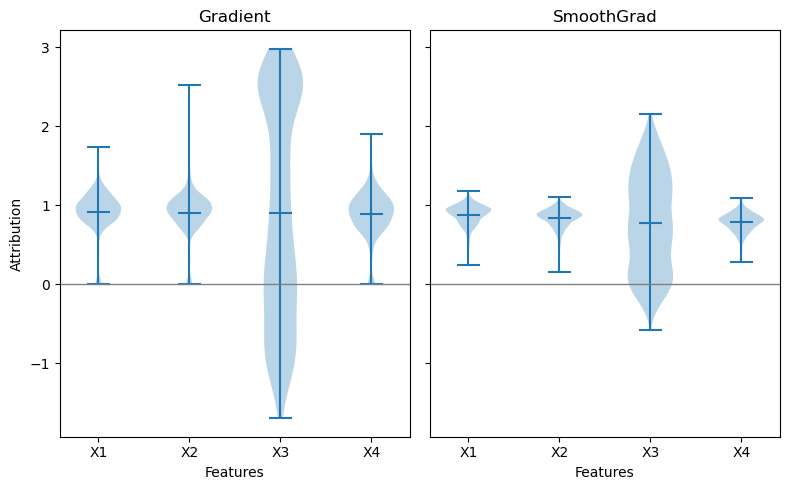

In [57]:
methods = ["Gradient", "SmoothGrad"]

attr_list = np.stack((attr_grad, attr_sm_grad))

plot_attr(methods, attr_list)

#### Plot of the distributions of the fixed-reference methods

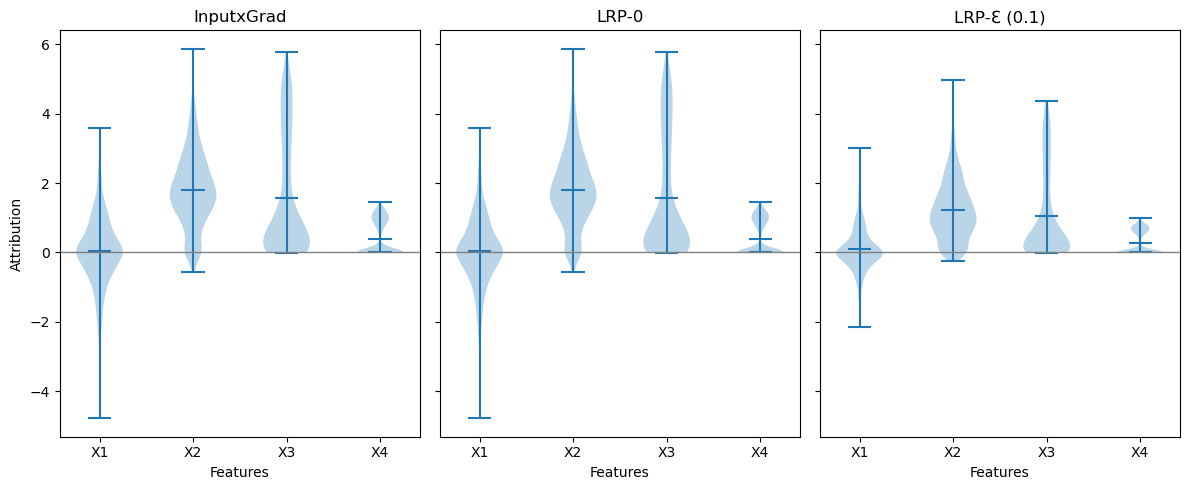

In [58]:
methods = ["InputxGrad", "LRP-0", "LRP-ℇ (0.1)"]

attr_list = np.stack((attr_ixg, attr_lrp_zero, attr_lrp_epsilon))

plot_attr(methods, attr_list)

#### Plot of the distributions of the reference-based methods

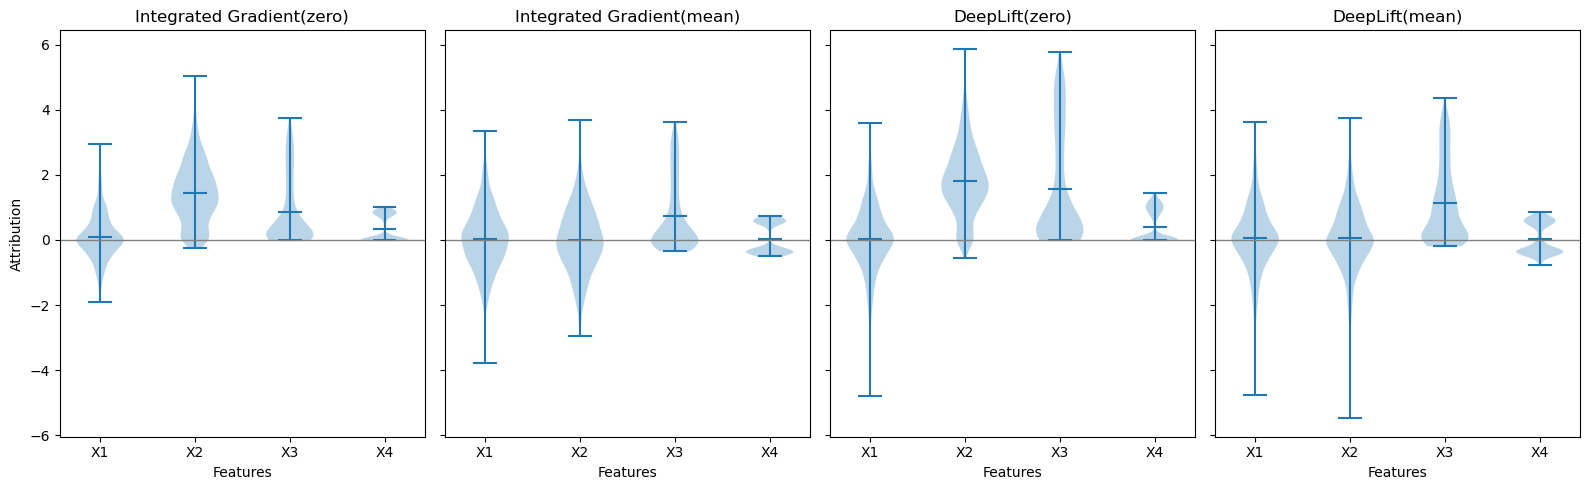

In [59]:
methods = ["Integrated Gradient(zero)", "Integrated Gradient(mean)", "DeepLift(zero)", "DeepLift(mean)"]

attr_list = np.stack((attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean))

plot_attr(methods, attr_list)